In [58]:
import numpy as np
from ctypes import *
import matplotlib.pyplot as plt

from optic.dsp.core import upsample, pnorm, pulseShape, firFilter
from optic.comm.modulation import modulateGray

### Tests the generation of a random bit sequence

In [2]:
outFile = "/home/silas/Documents/GitHub/TDI/src/dsp.so"
dsp = CDLL(outFile)

dsp.getRandomBits.argtypes = [c_int]
dsp.getRandomBits.restype  = POINTER(c_int)

(400000,)

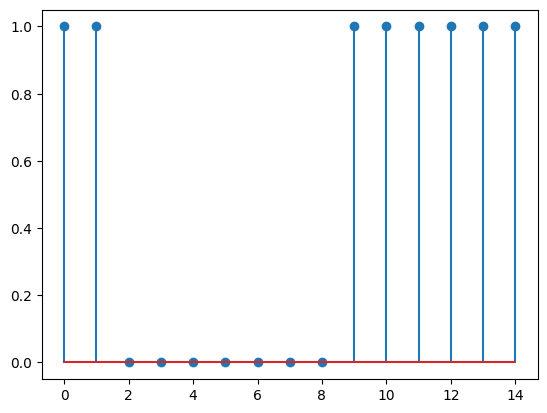

In [3]:
M = 16
Nbits = int(1e5*np.log2(M))

bits   = dsp.getRandomBits(Nbits, M)
# converte o ponteiro para um array numpy
bitsTx = np.ctypeslib.as_array(bits, shape=(Nbits,))

# imprime as primeiras 10 amostras de Nbits
plt.stem(bitsTx[0:15]);
bitsTx.shape

### Test for normalization in power

In [4]:
# Definindo a estrutura para representar números complexos
class Complex(Structure):
    _fields_ = [("real", c_float),
                ("imaginary", c_float)]

# funções auxiliares.
def complex2ctypes(numbers):
    return (Complex * len(numbers))(*(Complex(*index) for index in numbers))

def pointer2complex(arr, length):
    return [(arr[i].real, arr[i].imaginary) for i in range(length)]

def tuple2numpy(arr):
    return np.array([complex(x[0], x[1]) for x in arr], dtype=np.complex64)

### Define complex numbers as tuples

In [5]:
dsp.pnorm.restype = POINTER(Complex)            
dsp.pnorm.argtypes = [POINTER(Complex), c_int]

nums = [(1.0, 2.0), (3.0, 4.0)]     # define uma tuple como 1.0+2j, 3.0+4.0j
nums_array = complex2ctypes(nums)   # compatível com <complex.h>

result_ptr = dsp.pnorm(nums_array, len(nums))
result_ptr = pointer2complex(result_ptr, len(nums))

### Define complex numbers as numpy array

In [6]:
dsp.pnorm.restype = POINTER(Complex)
dsp.pnorm.argtypes = [np.ctypeslib.ndpointer(dtype=np.complex64, flags="C_CONTIGUOUS"), c_int]

nums = np.array([1.0 + 2.0j, 3.0 + 4.0j], dtype=np.complex64)

# chame a função pnorm
result_ptr = dsp.pnorm(nums, len(nums))
result_ptr = np.ctypeslib.as_array(result_ptr, shape=(nums.size,))

# compare o resultado
print(f"C code: {tuple2numpy(result_ptr)} \nOptiCommPy: {pnorm(np.array([1.0+2.0j, 3.0+4.0j]))}")

C code: [0.2581989+0.5163978j 0.7745967+1.0327955j] 
OptiCommPy: [0.25819889+0.51639778j 0.77459667+1.03279556j]


# Simulation - bits/modulation/normalization/upsampling 4-QAM

In [65]:
M = 4
SpS = 16
# Rs = 100e6              # Taxa de símbolos [símbolo/s]
# Ts = 1/Rs               # Período de símbolo em segundos
# Fa = 1/(Ts/SpS)         # Frequência de amostragem do sinal [amostras/segundo]
# Ta = 1/Fa               # Período de amostragem

Nbits = int(1e5*np.log2(M))

dsp.mainUpSymbols.restype = POINTER(Complex)
dsp.mainUpSymbols.argtypes = [c_int, c_int]

symbolsUp = dsp.mainUpSymbols(Nbits, SpS)
symbolsUp = np.ctypeslib.as_array(symbolsUp, shape=(int((Nbits/2)*SpS),))
symbolsUp = tuple2numpy(symbolsUp)

len(symbolsUp)

1600000

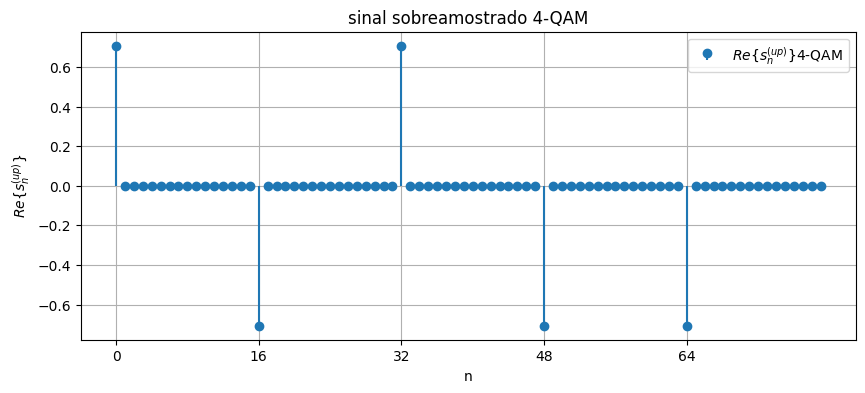

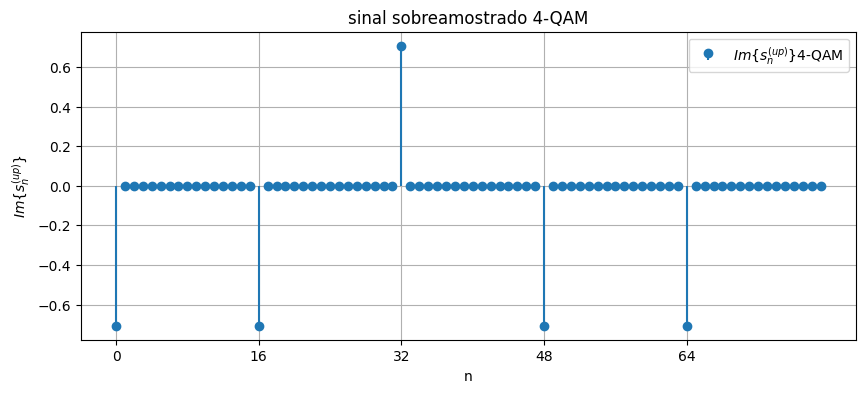

In [66]:
plt.figure(1, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].real, basefmt=" ", label ='$Re\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Re\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();

plt.figure(2, figsize=(10, 4))
plt.stem(symbolsUp[0:5*SpS].imag, basefmt=" ", label ='$Im\{s_n^{(up)}\}$'+str(M)+'-QAM')
plt.xlabel('n')
plt.ylabel('$Im\{s_n^{(up)}\}$')
plt.legend(loc='upper right')
plt.xticks(np.arange(0, 5*SpS, SpS))
plt.title('sinal sobreamostrado '+str(M)+'-QAM')
plt.grid();